In [1]:
# CBOW (Continuous Bag-of-Words)

import torch

sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss", "Xiaobing is Student", "Xiaoxue is Student"]
words = ' '.join(sentences).split()
# 去除重复单词
word_list = list(set(words))

word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
# print(word_to_idx)
# print(idx_to_word)
voc_size = len(word_list)
print("词汇表", word_list)
print("词汇到索引", word_to_idx)
print("索引到词汇", idx_to_word)
print("词汇表大小", voc_size)

词汇表 ['Student', 'Teacher', 'Xiaobing', 'Niuzong', 'Xiaoxue', 'Mazong', 'Boss', 'Kage', 'is']
词汇到索引 {'Student': 0, 'Teacher': 1, 'Xiaobing': 2, 'Niuzong': 3, 'Xiaoxue': 4, 'Mazong': 5, 'Boss': 6, 'Kage': 7, 'is': 8}
索引到词汇 {0: 'Student', 1: 'Teacher', 2: 'Xiaobing', 3: 'Niuzong', 4: 'Xiaoxue', 5: 'Mazong', 6: 'Boss', 7: 'Kage', 8: 'is'}
词汇表大小 9


In [3]:
# 获取上下文词汇，将当前单词前后各N个单词作为周围词
def create_cbow_dataset(sentences, window_size=2):
    # print(window_size)
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            context_words = sentence[max(idx-window_size, 0):idx] + sentence[idx+1:min(idx+window_size+1, len(sentence))]
            data.append((word, context_words))
    return data

cbow_datas = create_cbow_dataset(sentences, window_size=2)
print("CBOW 数据样例:", cbow_datas[:3])

CBOW 数据样例: [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [17]:
import torch.nn as nn

def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, debug=False):
        super(CBOW, self).__init__()
        self.input_to_hidden = nn.Linear(vocab_size, embedding_size)
        self.hidden_to_output = nn.Linear(embedding_size, vocab_size)
        self.debug = debug

    def forward(self, X): 
        # X: [num_context_words, voc_size]
        embeddings = self.input_to_hidden(X)
        
        hidden_layer = torch.mean(embeddings, dim=0)
        if self.debug:
            print("embeddings.shape", embeddings.shape)
            print("hidden layer.shape", hidden_layer.shape)
            print("hidden layer.unsqueeze(0).shape", hidden_layer.unsqueeze(0).shape)
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0))
        return output_layer



CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=True)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=True)
)
Epoch 100, Loss: 2.109607489903768
Epoch 200, Loss: 2.0495461146036784
Epoch 300, Loss: 2.014638153711955
Epoch 400, Loss: 1.9912923892339072
Epoch 500, Loss: 1.9735337416330974
Epoch 600, Loss: 1.9584661404291788
Epoch 700, Loss: 1.9445192575454713
Epoch 800, Loss: 1.9307057778040568
Epoch 900, Loss: 1.9162915786107382
Epoch 1000, Loss: 1.9006402174631754


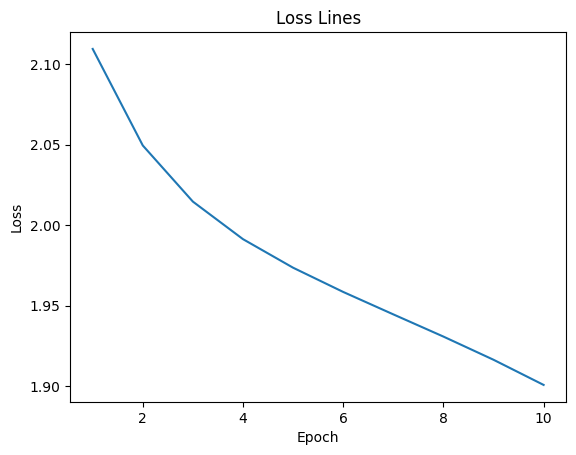

In [29]:
embedding_size=2
cbow_model = CBOW(voc_size, embedding_size, debug=False)
print(cbow_model)

learning_rate = 0.001 
epoches = 1000
loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(epoches):
    loss_sum = 0
    for target, context_words in cbow_datas:
        # **cbow用周围词预测中心词**
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float()
        
        # print(X.shape)
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
        # print(y_true.shape)
        y_pred = cbow_model(X)
        # print(y_pred.shape)
        loss = loss_fn(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("X.shape", X.shape)
        # print("y_true.shape", y_true.shape)
        # print("y_pred.shape", y_pred.shape)
        # break
    if (epoch + 1) % 100 == 0:
        cur_loss = loss_sum/len(cbow_datas)
        print(f"Epoch {epoch+1}, Loss: {cur_loss}")
        loss_values.append(cur_loss)

import matplotlib.pyplot as plt

plt.plot(range(1, epoches//100 + 1), loss_values)
plt.title("Loss Lines")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()